## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'syntheticMRI2D-axial' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
diagonal_wavelet_axial_syntheticMRI2D.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI2D/axial/wavelet/diagonal'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 4,
 3: 20050,
 4: 180942,
 5: 922650,
 6: 4185552,
 7: 17688454,
 8: 72685058,
 9: 295085108}

Running 12760 CDFs


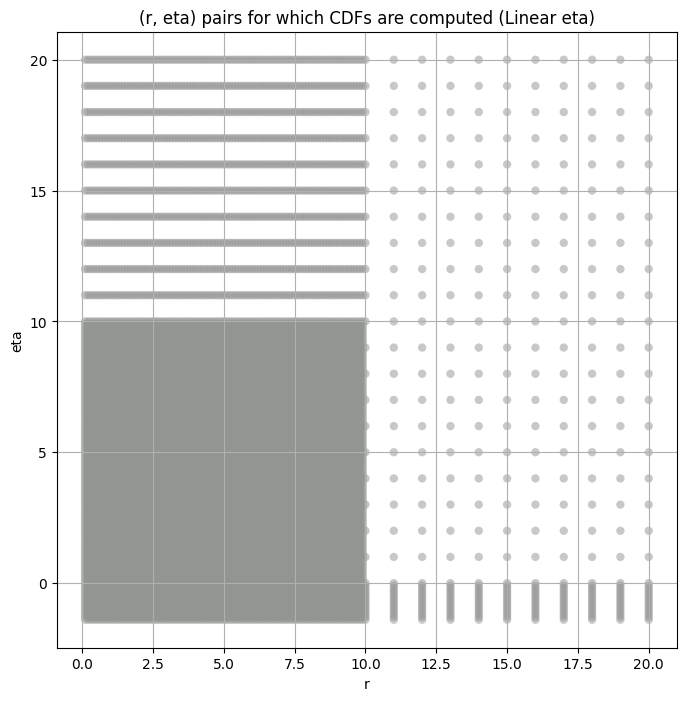

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var      var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                      
2      1.128047e+06       0.000000  2.227615e+06   -1.049854         NaN   
3      4.056535e+05  396542.340000  4.146855e+05   -1.240346   -1.274471   
4      1.365078e+05  130978.300000  1.420548e+05    0.494698    0.342358   
5      3.048242e+04   28617.070000  3.245099e+04    3.911668    2.808647   
6      1.398417e+04   12737.206000  1.529985e+04   10.707630    9.402235   
7      1.169774e+03    1043.950200  1.302599e+03   16.788366   13.570639   
8      5.038604e+01      41.927715  7.069757e+01  114.181786   14.985191   
9      2.155626e+00       1.522823  4.376486e+00  680.612400   18.725904   

        kurt_upper  total_samples  
layer                              
2              NaN              4  
3        -1.203905          20050  
4         0.693687         180942  
5         5.579560         922650  
6        12.093122        4185552  
7        21.554005       17688454  
8       479.179440       72685058  
9      1771.118300      295085108

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      1.128047e+06   1.128047e+06             NaN             NaN   
3      4.056535e+05   4.056535e+05   400973.062500   397434.062500   
4      1.365078e+05   1.365078e+05   135523.656250   134768.234375   
5      3.048242e+04   3.048242e+04    29763.546875    29329.353516   
6      1.398417e+04   1.398417e+04    13626.451172    13326.069336   
7      1.169774e+03   1.169774e+03     1119.991821     1083.356079   
8      5.038604e+01   5.038604e+01       44.228893       42.482258   
9      2.155626e+00   2.155626e+00        1.595577        1.510954   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2                 NaN              NaN              NaN              NaN   
3       394219.968750    391285.218750    385948.625000    381049.000000   
4       134062.328125    133388.687500    132110.046875    130913.632812   
5        28973.326172     28657.806641     28099.228516     27606.107422   
6        13054.405273     12803.336914     12348.862305     11941.977539   
7         1052.170288      1024.717651       977.461670       937.018311   
8           41.104084        39.934032        37.974052        36.338688   
9            1.449227         1.399144         1.319434         1.256501   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2                  NaN              NaN              NaN              NaN  
3        376500.281250    372207.218750    368064.187500    356461.187500  
4        129777.726562    128686.234375    127637.992188    124689.078125  
5         27159.474609     26747.951172     26363.511719     25331.869141  
6         11571.955078     11231.651367     10916.194336     10085.484375  
7           901.251221       868.960327       839.440979       763.498840  
8            34.917923        33.655987        32.518444        29.645119  
9             1.204315         1.159671         1.120619         1.026149

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.17680065488163454 1128046.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 nan nan
Number of samples: 4, Without approximation : 4


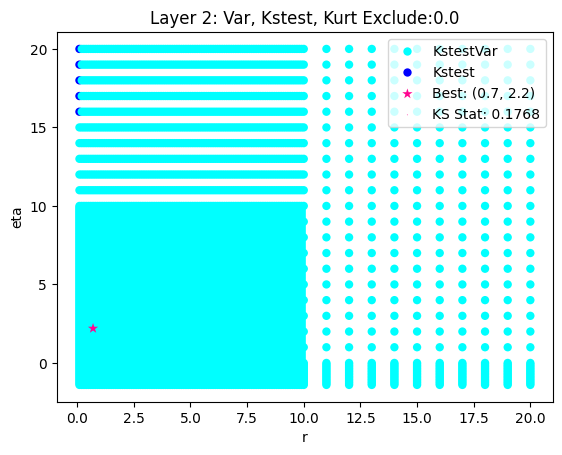

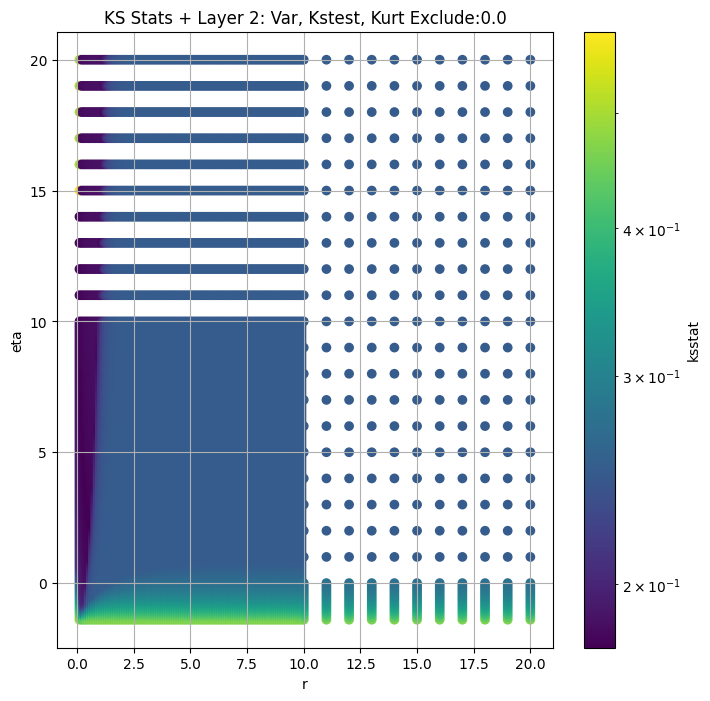

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.08427637423914802 405653.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.08556871835829649 400973.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.08655822424822898 397434.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.08746626452065565 394219.97


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.08820124668655799 391285.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.08974927363387716 385948.62


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.09119511687686616 381049.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.09255758850936344 376500.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.09386173294591149 372207.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.09513748810638667 368064.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.0988034520574615 356461.2
Number of samples: 20050, Without approximation : 20050


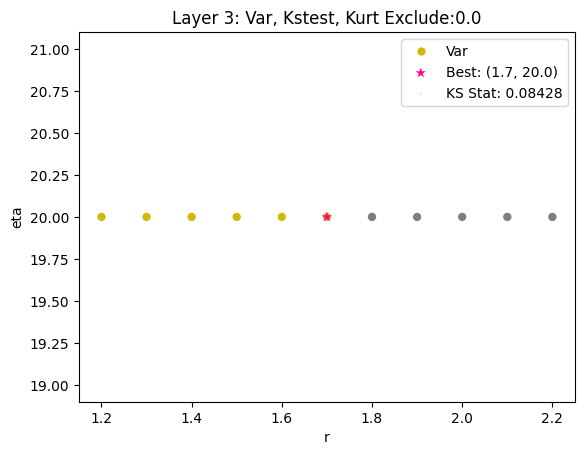

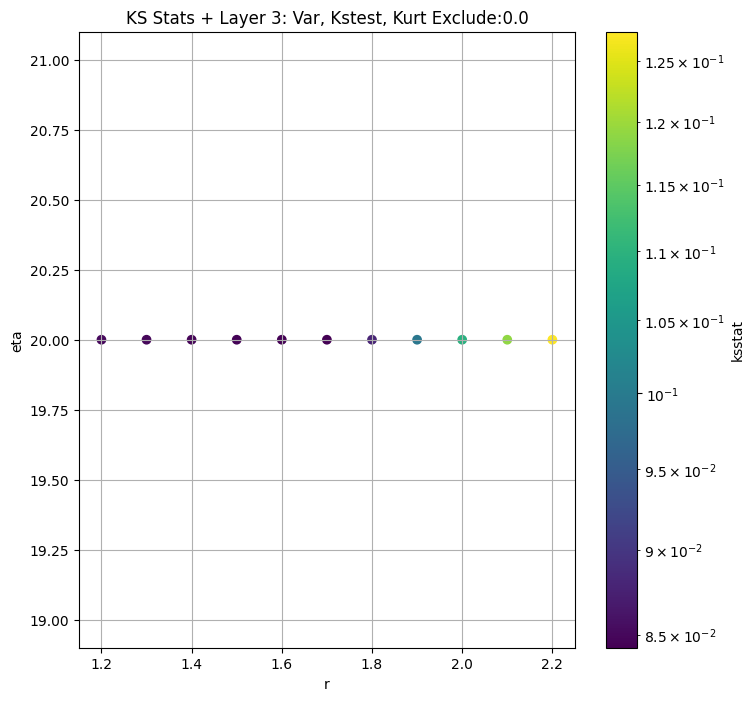

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.004389517694543016 136507.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.004862806824580665 135523.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.005288067540491374 134768.23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.005681694499442794 134062.33


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.006016812120863316 133388.69


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.006721263888904032 132110.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.0074023051937328055 130913.63


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.008045154901836209 129777.73


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.00870030013839155 128686.234


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.009340243411254244 127637.99


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.011143000974060034 124689.08
Number of samples: 100000, Without approximation : 180942


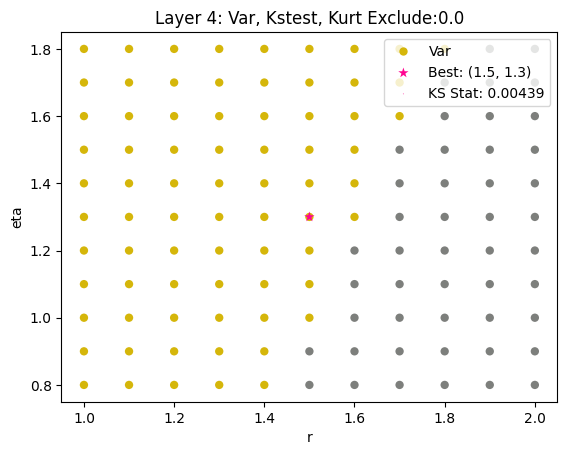

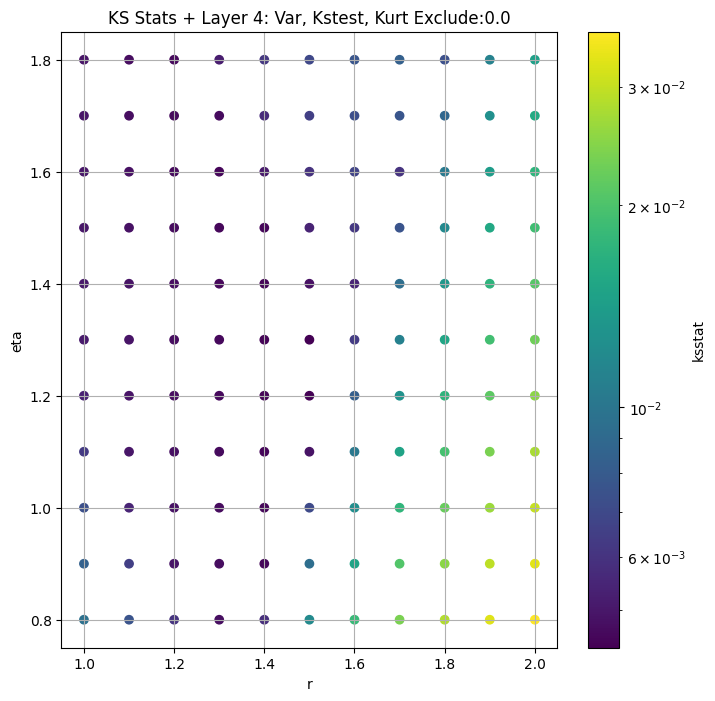

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.00516950105628472 30482.424


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.004470710980223169 29763.547


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.004618364711650336 29329.354


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.004261582396570818 28973.326


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.004169485701824849 28657.807


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.003448233234752962 28099.229


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.004096657288192307 27606.107


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.004698903521664313 27159.475


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.005284283780394361 26747.951


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.005800813151083953 26363.512


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.007365054281515737 25331.87
Number of samples: 100000, Without approximation : 922650


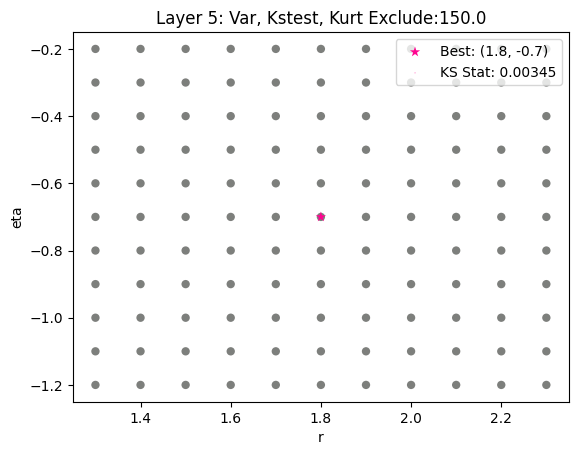

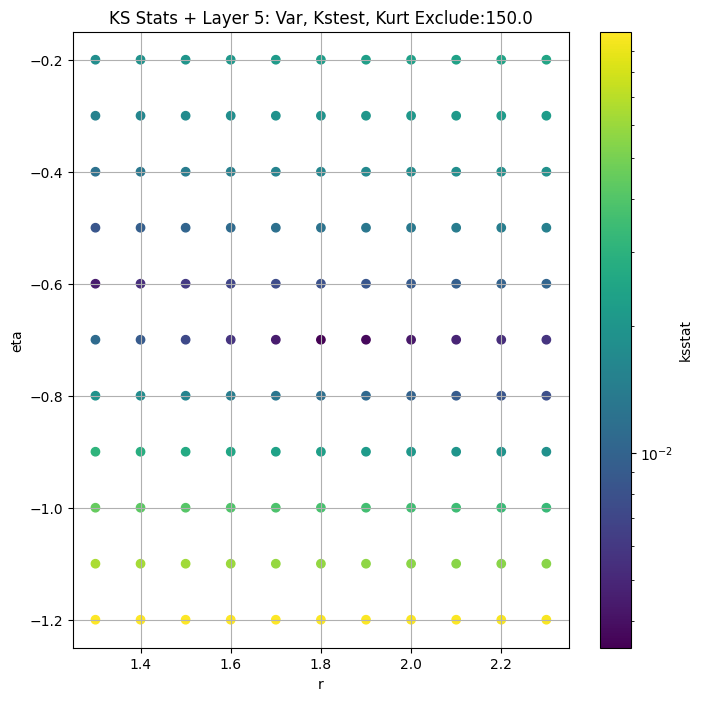

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.011995564587785834 13984.172


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.011649771831574673 13626.451


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.013197742417344394 13326.069


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.012132543083343439 13054.405


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.012005497244642616 12803.337


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.011181323565230772 12348.862


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.011159256806744955 11941.978


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.01010962020890882 11571.955


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.009214249550401538 11231.651


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.010084814045191293 10916.194


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.010139253175735732 10085.484
Number of samples: 100000, Without approximation : 4185552


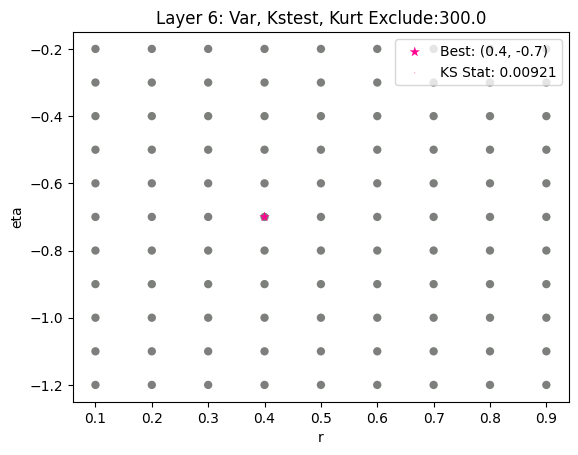

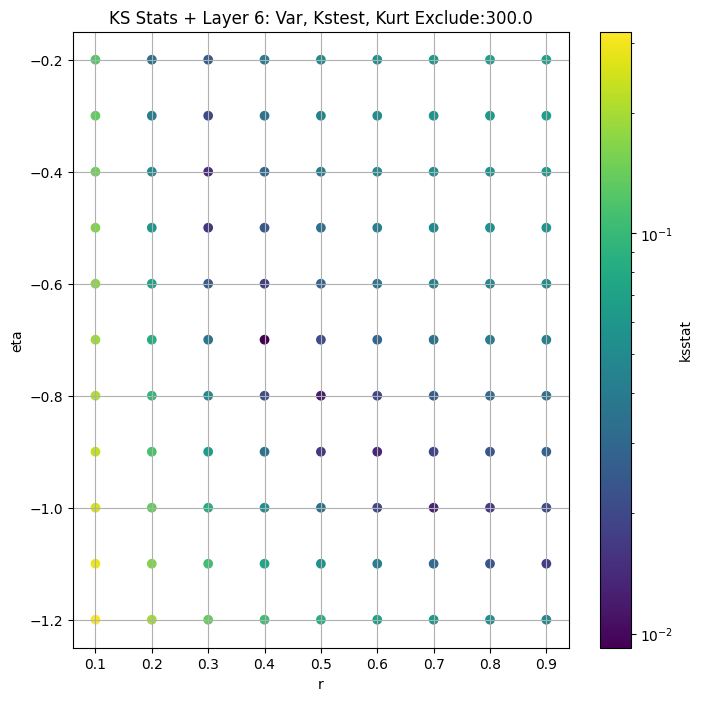

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.006944865001104722 1169.7737


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.006762207415486832 1119.9918


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.005526224482836198 1083.3561


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.0050608413237955285 1052.1703


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.006913183817134794 1024.7177


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.005561848925625945 977.4617


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.005866700730142095 937.0183


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.006051743637919715 901.2512


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.006621377874108658 868.9603


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.006952154515338876 839.441


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.008405985394622895 763.49884
Number of samples: 100000, Without approximation : 17688454


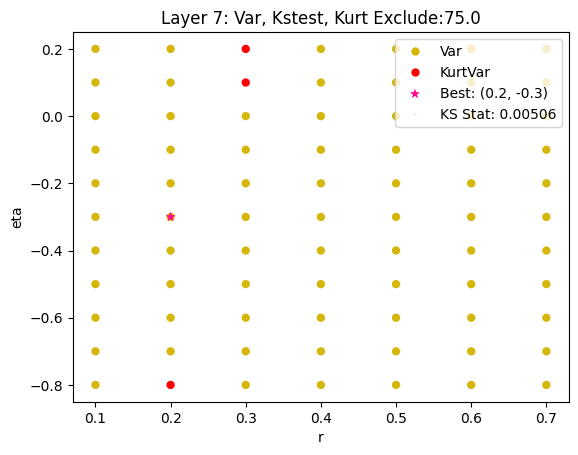

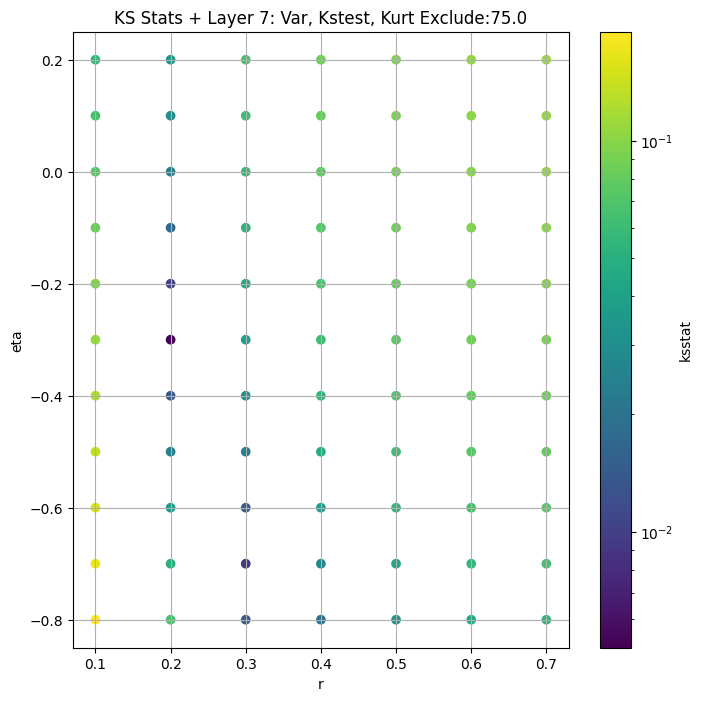

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.006120433730318564 50.38604


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.0032951678833649523 44.228893


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.003928251785431679 42.482258


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.004442728894930359 41.104084


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.004888482808316837 39.934032


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.00472948038326871 37.974052


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.0057562863166434886 36.338688


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.006463140208047502 34.917923


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.006461952929330061 33.655987


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007260715209307156 32.518444


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.008840785616712032 29.645119
Number of samples: 100000, Without approximation : 72685058


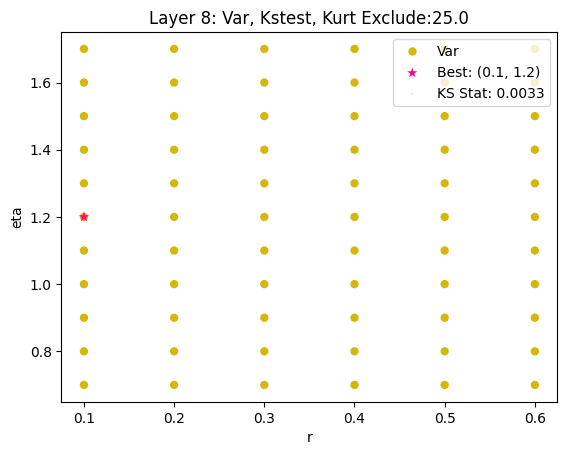

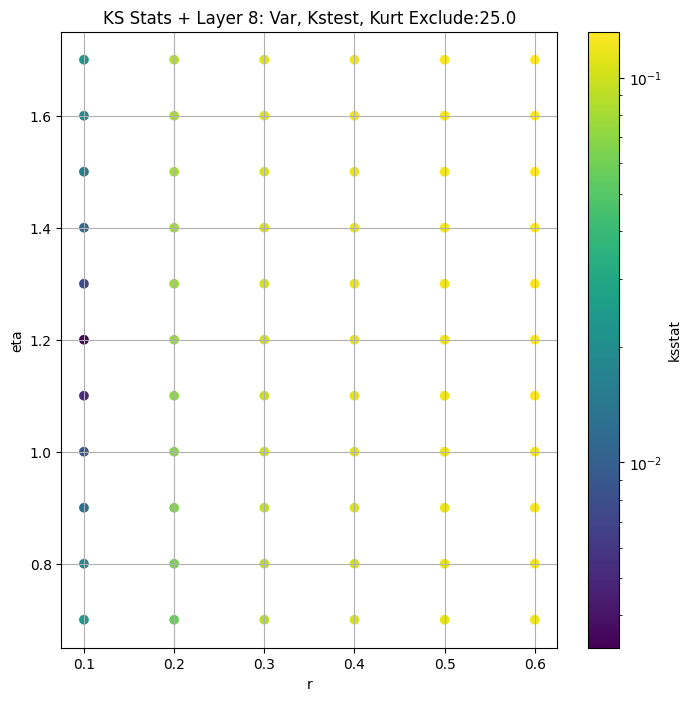

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.022898368136352654 2.1556256


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.015327946543471804 1.5955766


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.013736929364457917 1.510954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.012559298697362553 1.4492273


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.011669423043270344 1.3991438


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.010108669149791638 1.3194343


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.008835938421423523 1.2565007


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.007550960322550204 1.2043146


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.006432240829435276 1.159671


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.006108436158563824 1.1206194


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.007666241744491731 1.0261492
Number of samples: 100000, Without approximation : 295085108


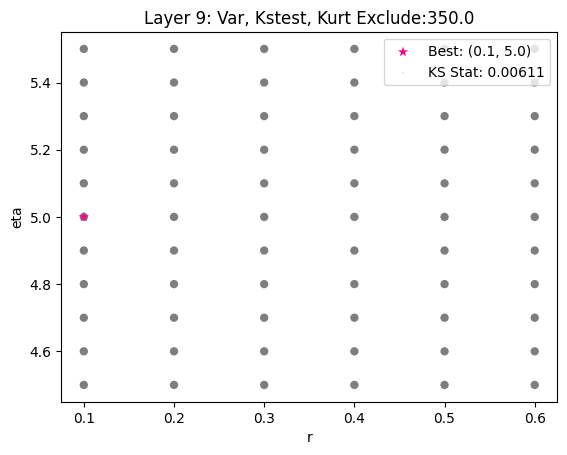

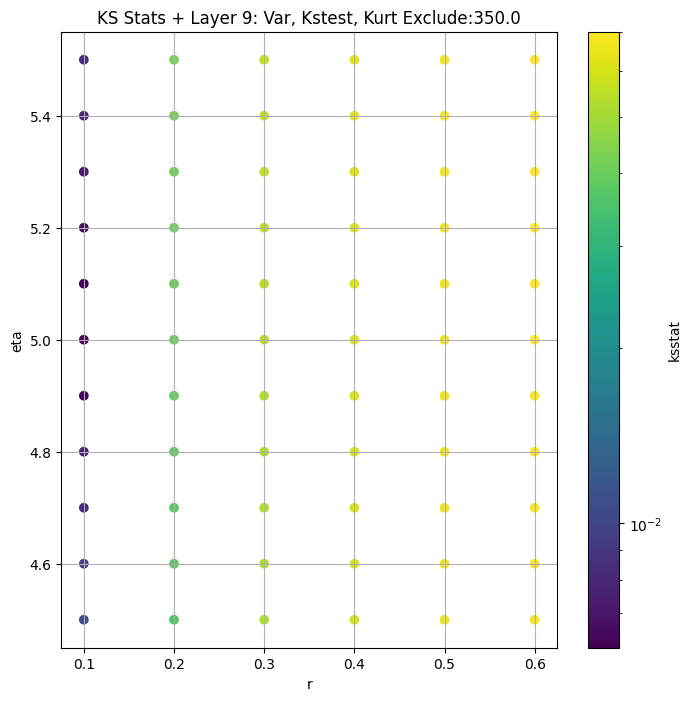

obs_var      var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                      
2      1.128047e+06       0.000000  2.227615e+06   -1.049854         NaN   
3      4.056535e+05  396542.340000  4.146855e+05   -1.240346   -1.274471   
4      1.365078e+05  130978.300000  1.420548e+05    0.494698    0.342358   
5      3.048242e+04   28617.070000  3.245099e+04    3.911668    2.808647   
6      1.398417e+04   12737.206000  1.529985e+04   10.707630    9.402235   
7      1.169774e+03    1043.950200  1.302599e+03   16.788366   13.570639   
8      5.038604e+01      41.927715  7.069757e+01  114.181786   14.985191   
9      2.155626e+00       1.522823  4.376486e+00  680.612400   18.725904   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2              NaN              4             0.176801        0.7   
3        -1.203905          20050             0.084276        1.7   
4         0.693687         180942             0.004390        1.5   
5         5.579560         922650             0.003448        1.8   
6        12.093122        4185552             0.009214        0.4   
7        21.554005       17688454             0.005061        0.2   
8       479.179440       72685058             0.003295        0.1   
9      1771.118300      295085108             0.006108        0.1   

       initial_eta  initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                                           
2              2.2   9.898170e+04                     0.0        1.128047e+06   
3             20.0   9.206067e+04                     0.0        4.056535e+05   
4              1.3   9.534650e+04                     0.0        1.365078e+05   
5             -0.7   5.599877e+04                   150.0        2.809923e+04   
6             -0.7   9.656047e+02                   300.0        1.123165e+04   
7             -0.3   3.479399e-02                    75.0        1.052170e+03   
8              1.2   4.795015e-14                    25.0        4.422889e+01   
9              5.0   4.298576e-19                   350.0        1.120619e+00   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.623939  
3                     0.009583  
4                     0.003192  
5                     0.001414  
6                     0.000664  
7                     0.000323  
8                     0.000159  
9                     0.000079

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
layer 2, 0.0 + 100 = 100, ksstat: nan, var: nan


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
layer 2, 0.0 + 75 = 75, ksstat: nan, var: nan


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
layer 2, 0.0 + 50 = 50, ksstat: nan, var: nan


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
layer 2, 0.0 + 25 = 25, ksstat: nan, var: nan


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.17680065488163454, var: 1128046.625
Number of samples: 4, Without approximation : 4


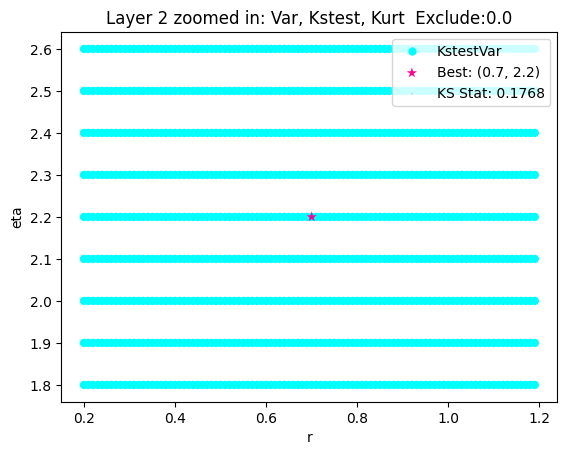

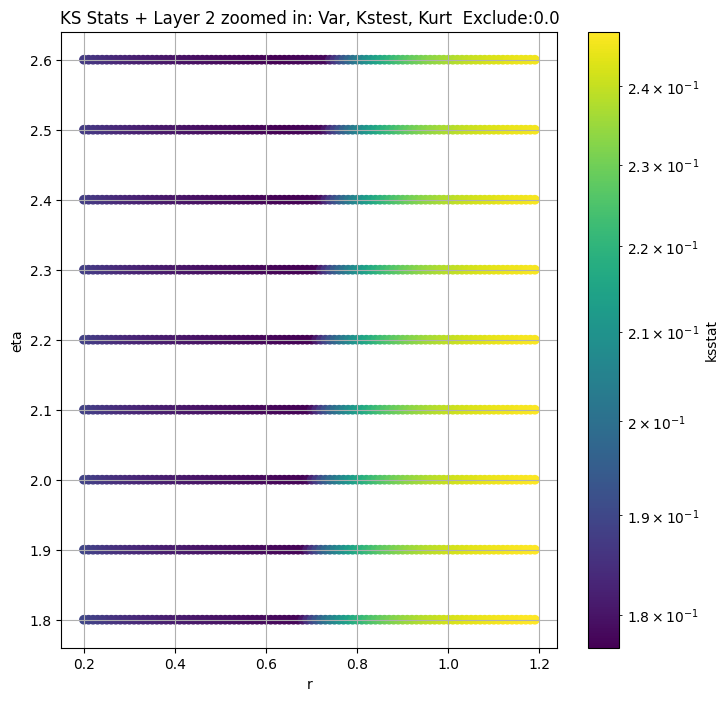

Layer 3


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.08820124668655799, var: 391285.21875


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.08737388568561189, var: 394219.96875


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.08647564204957661, var: 397434.0625


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.08548612420902327, var: 400973.0625


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.0842036917276964, var: 405653.5
Number of samples: 20050, Without approximation : 20050


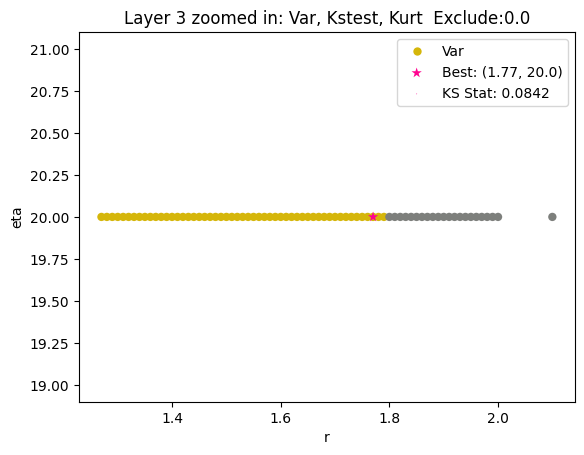

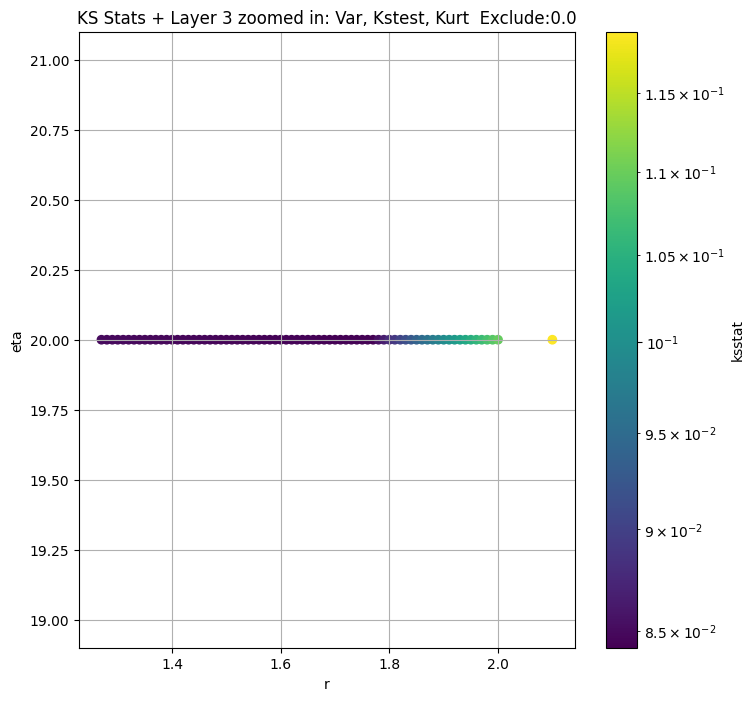

Layer 4


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.006006737386671221, var: 133388.6875


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.0056380021759740995, var: 134062.328125


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.005257374146594773, var: 134768.234375


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.004862806824580665, var: 135523.65625


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.004373024260144388, var: 136507.84375
Number of samples: 100000, Without approximation : 180942


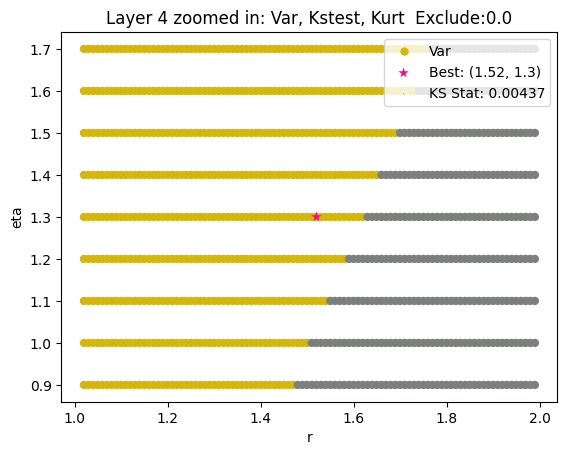

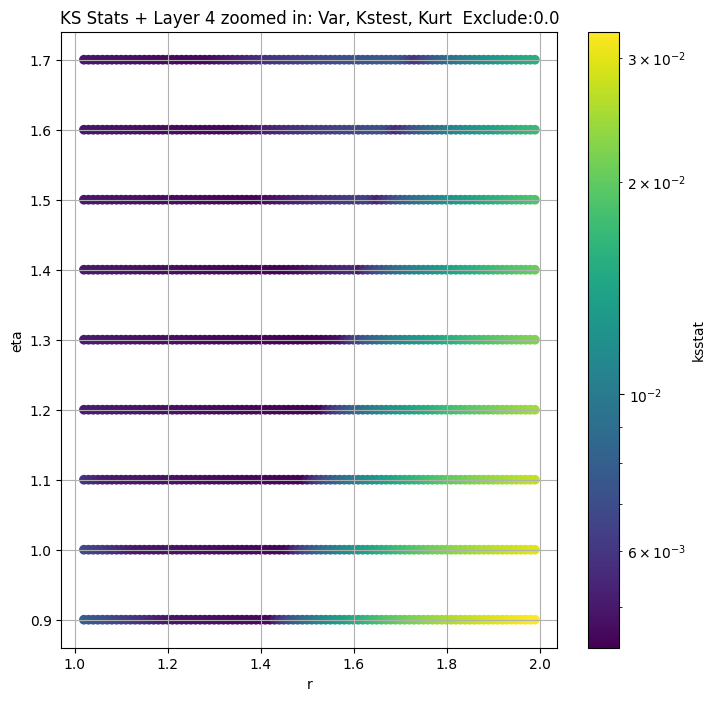

Layer 5


  0%|          | 0/1360 [00:00<?, ?it/s]

Finding Minimum after computing 1360 CDFs
layer 5, 150.0 + 100 = 250, ksstat: 0.004650025590637742, var: 27159.474609375


  0%|          | 0/1360 [00:00<?, ?it/s]

Finding Minimum after computing 1360 CDFs
layer 5, 150.0 + 75 = 225, ksstat: 0.004367075334968162, var: 27377.8984375


  0%|          | 0/1360 [00:00<?, ?it/s]

Finding Minimum after computing 1360 CDFs
layer 5, 150.0 + 50 = 200, ksstat: 0.0040673103350825635, var: 27606.107421875


  0%|          | 0/1360 [00:00<?, ?it/s]

Finding Minimum after computing 1360 CDFs
layer 5, 150.0 + 25 = 175, ksstat: 0.003750709277284936, var: 27846.29296875


  0%|          | 0/1360 [00:00<?, ?it/s]

Finding Minimum after computing 1360 CDFs
layer 5, 150.0 + 0 = 150, ksstat: 0.0034375139395893036, var: 28099.228515625


  0%|          | 0/1360 [00:00<?, ?it/s]

Finding Minimum after computing 1360 CDFs
layer 5, 150.0 + -25 = 125, ksstat: 0.0035170227517232755, var: 28369.1484375


  0%|          | 0/1360 [00:00<?, ?it/s]

Finding Minimum after computing 1360 CDFs
layer 5, 150.0 + -50 = 100, ksstat: 0.003495356629772184, var: 28657.806640625


  0%|          | 0/1360 [00:00<?, ?it/s]

Finding Minimum after computing 1360 CDFs
layer 5, 150.0 + -75 = 75, ksstat: 0.0036643496960289124, var: 28973.326171875


  0%|          | 0/1360 [00:00<?, ?it/s]

Finding Minimum after computing 1360 CDFs
layer 5, 150.0 + -100 = 50, ksstat: 0.004264005386327985, var: 29329.353515625
Number of samples: 100000, Without approximation : 922650


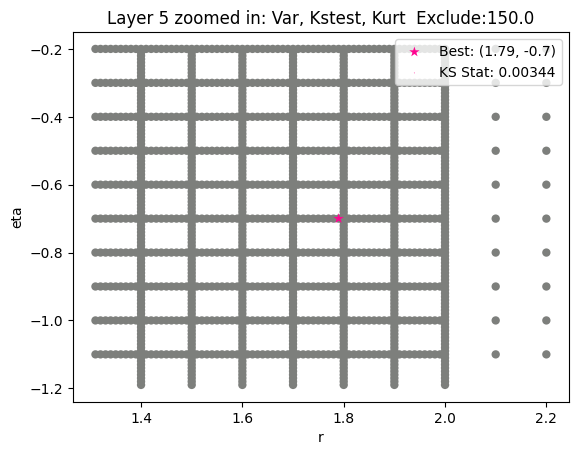

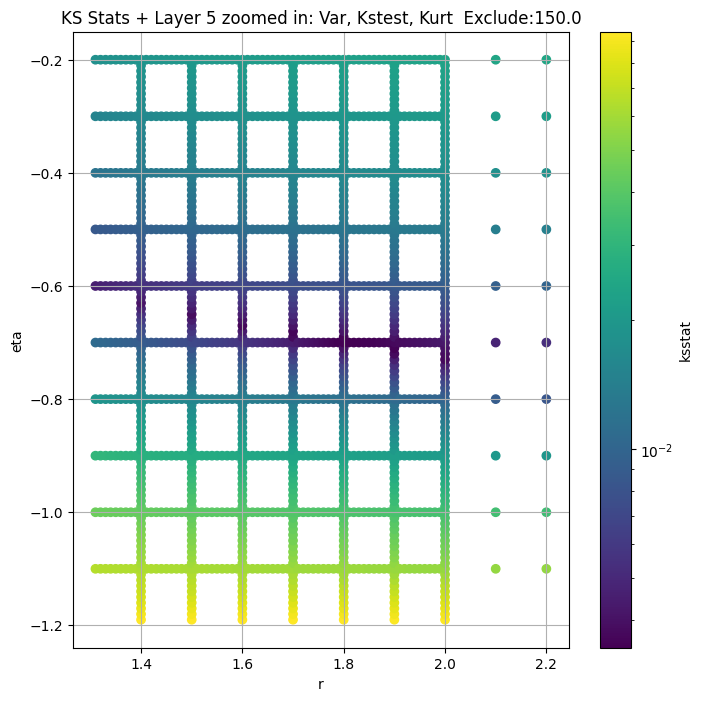

Layer 6


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 6, 300.0 + 100 = 400, ksstat: 0.008767714762771106, var: 10621.7158203125


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 6, 300.0 + 75 = 375, ksstat: 0.008494850103355933, var: 10766.4384765625


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 6, 300.0 + 50 = 350, ksstat: 0.008497968243530662, var: 10916.1943359375


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 6, 300.0 + 25 = 325, ksstat: 0.008597833851845552, var: 11071.1396484375


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 6, 300.0 + 0 = 300, ksstat: 0.009185784193073643, var: 11231.6513671875


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 6, 300.0 + -25 = 275, ksstat: 0.00924124467386378, var: 11398.4482421875


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 6, 300.0 + -50 = 250, ksstat: 0.009201361435278277, var: 11571.955078125


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 6, 300.0 + -75 = 225, ksstat: 0.009207679094539456, var: 11752.837890625


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 6, 300.0 + -100 = 200, ksstat: 0.009285425039778195, var: 11941.9775390625
Number of samples: 100000, Without approximation : 4185552


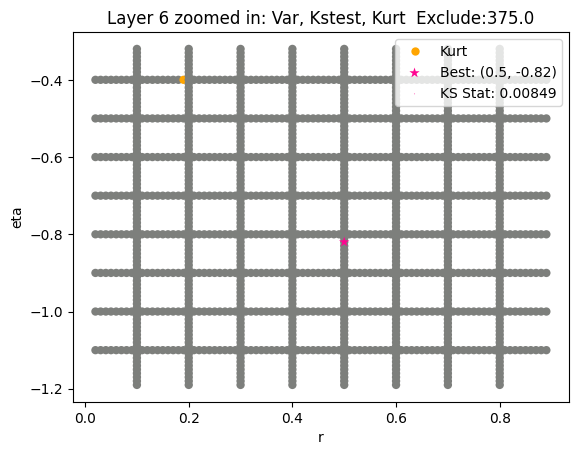

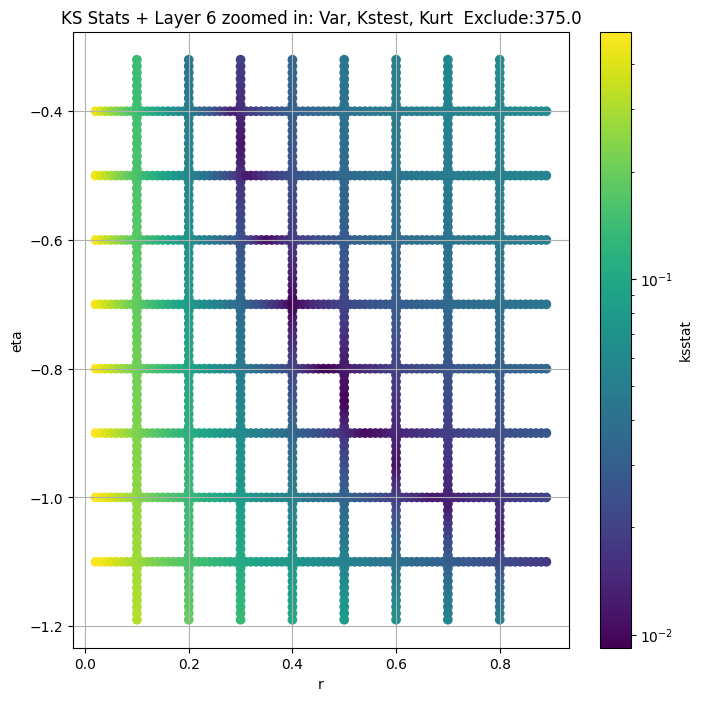

Layer 7


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 75.0 + 100 = 175, ksstat: 0.005091553387300246, var: 956.5621948242188


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 75.0 + 75 = 150, ksstat: 0.004967740774595275, var: 977.461669921875


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 75.0 + 50 = 125, ksstat: 0.004872736310205794, var: 1000.0355834960938


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 75.0 + 25 = 100, ksstat: 0.004518620059548032, var: 1024.7176513671875


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 75.0 + 0 = 75, ksstat: 0.004296960406802122, var: 1052.1702880859375


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 75.0 + -25 = 50, ksstat: 0.004826611046335402, var: 1083.3560791015625


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 75.0 + -50 = 25, ksstat: 0.004699486623316651, var: 1119.9918212890625


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 75.0 + -75 = 0, ksstat: 0.006304846916071541, var: 1169.773681640625
Number of samples: 100000, Without approximation : 17688454


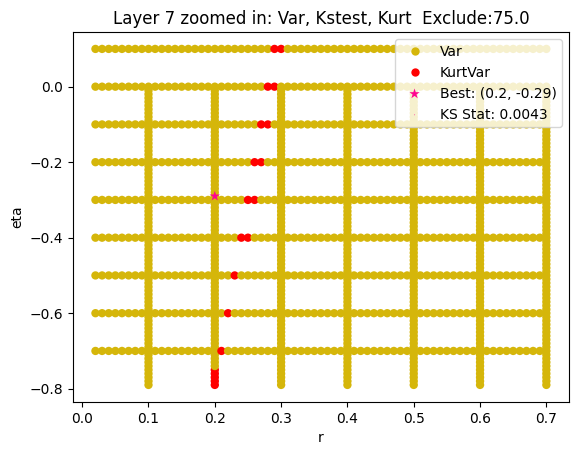

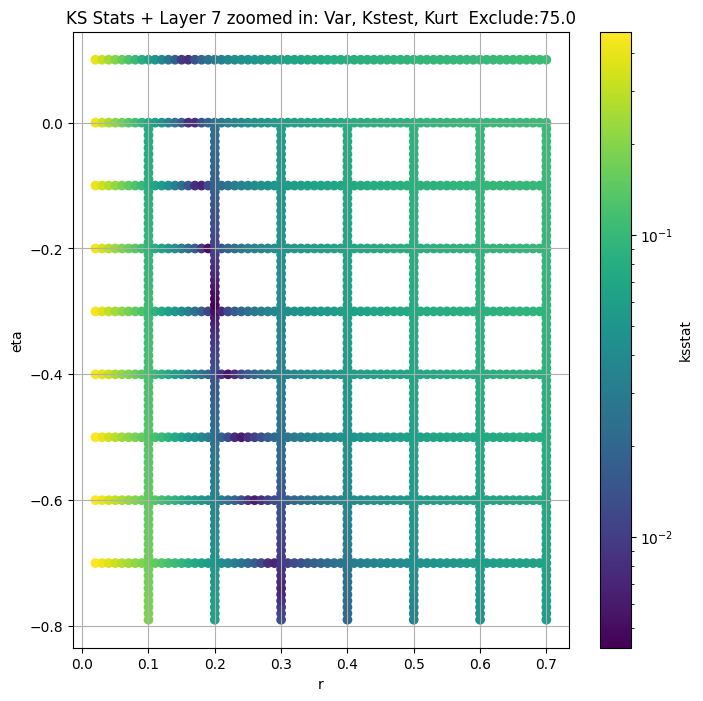

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.005190064860798427, var: 38.90285110473633


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.004786420189144658, var: 39.93403244018555


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.004130868794043452, var: 41.10408401489258


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.0035823453188120746, var: 42.48225784301758


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.0031956114337117793, var: 44.2288932800293


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.005032285096565392, var: 50.38603973388672
Number of samples: 100000, Without approximation : 72685058


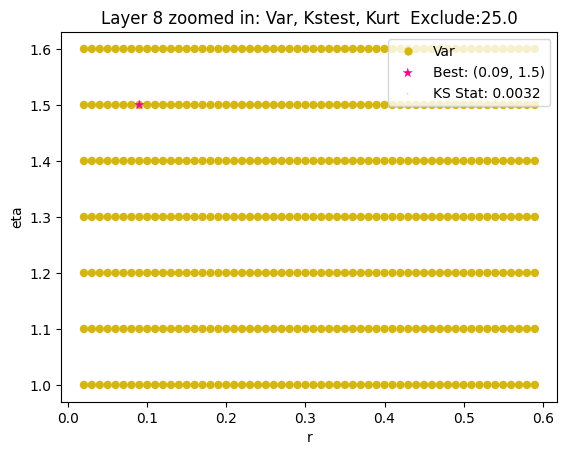

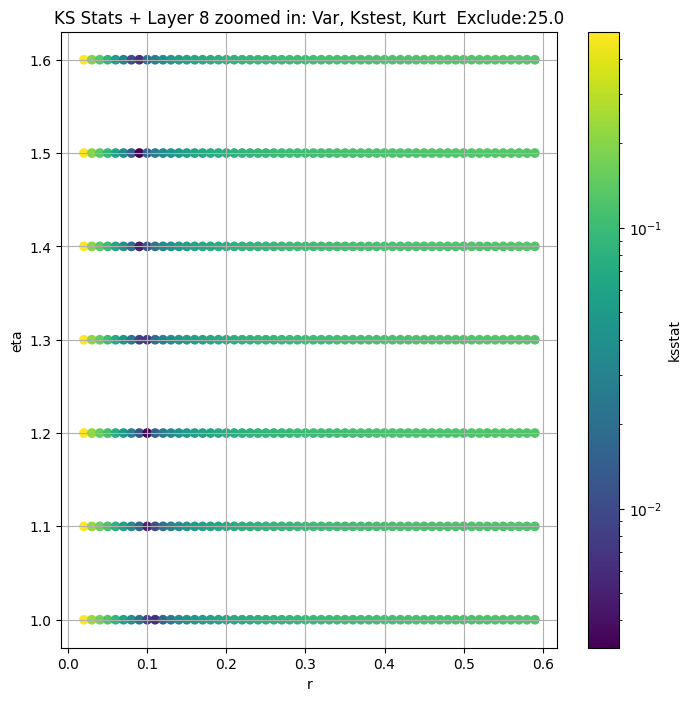

Layer 9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 350.0 + 100 = 450, ksstat: 0.007180476096485977, var: 1.0545949935913086


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 350.0 + 75 = 425, ksstat: 0.00689467265881849, var: 1.069847583770752


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 350.0 + 50 = 400, ksstat: 0.00661739013708551, var: 1.0858770608901978


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 350.0 + 25 = 375, ksstat: 0.006391001339840496, var: 1.1027666330337524


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 350.0 + 0 = 350, ksstat: 0.006108436158563824, var: 1.1206194162368774


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 350.0 + -25 = 325, ksstat: 0.006176369326209685, var: 1.1395394802093506


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 350.0 + -50 = 300, ksstat: 0.00619687087745846, var: 1.1596709489822388


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 350.0 + -75 = 275, ksstat: 0.006957685701991567, var: 1.1811949014663696


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 350.0 + -100 = 250, ksstat: 0.007471244437501134, var: 1.2043145895004272
Number of samples: 100000, Without approximation : 295085108


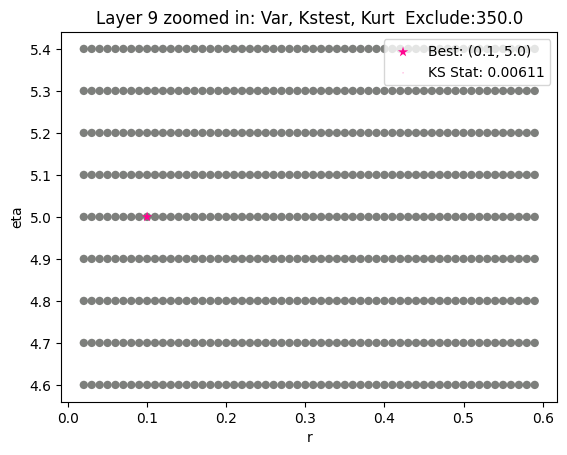

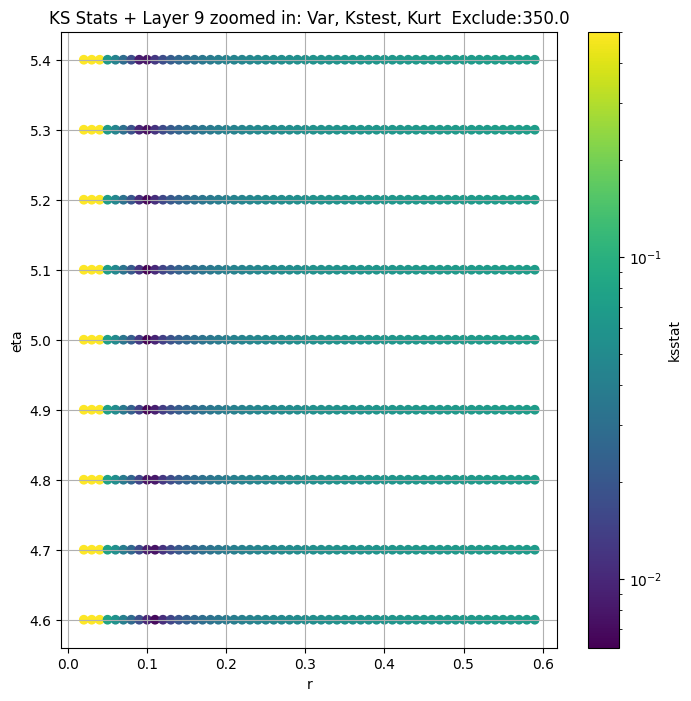

obs_var      var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                      
2      1.128047e+06       0.000000  2.227615e+06   -1.049854         NaN   
3      4.056535e+05  396542.340000  4.146855e+05   -1.240346   -1.274471   
4      1.365078e+05  130978.300000  1.420548e+05    0.494698    0.342358   
5      3.048242e+04   28617.070000  3.245099e+04    3.911668    2.808647   
6      1.398417e+04   12737.206000  1.529985e+04   10.707630    9.402235   
7      1.169774e+03    1043.950200  1.302599e+03   16.788366   13.570639   
8      5.038604e+01      41.927715  7.069757e+01  114.181786   14.985191   
9      2.155626e+00       1.522823  4.376486e+00  680.612400   18.725904   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2              NaN              4             0.176801        0.7   
3        -1.203905          20050             0.084276        1.7   
4         0.693687         180942             0.004390        1.5   
5         5.579560         922650             0.003448        1.8   
6        12.093122        4185552             0.009214        0.4   
7        21.554005       17688454             0.005061        0.2   
8       479.179440       72685058             0.003295        0.1   
9      1771.118300      295085108             0.006108        0.1   

       initial_eta  initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                                           
2              2.2   9.898170e+04                     0.0        1.128047e+06   
3             20.0   9.206067e+04                     0.0        4.056535e+05   
4              1.3   9.534650e+04                     0.0        1.365078e+05   
5             -0.7   5.599877e+04                   150.0        2.809923e+04   
6             -0.7   9.656047e+02                   300.0        1.076644e+04   
7             -0.3   3.479399e-02                    75.0        1.052170e+03   
8              1.2   4.795015e-14                    25.0        4.422889e+01   
9              5.0   4.298576e-19                   350.0        1.120619e+00   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.623939          0.176801    0.70      2.20   
3                     0.009583          0.084204    1.77     20.00   
4                     0.003192          0.004373    1.52      1.30   
5                     0.001414          0.003438    1.79     -0.70   
6                     0.000664          0.008495    0.50     -0.82   
7                     0.000323          0.004297    0.20     -0.29   
8                     0.000159          0.003196    0.09      1.50   
9                     0.000079          0.006108    0.10      5.00   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      9.898170e+04                  0.0           57  
3      9.996494e+04                  0.0          262  
4      9.685953e+04                  0.0       101779  
5      5.586394e+04                150.0       164209  
6      3.354449e+03                375.0        24523  
7      3.369233e-02                 75.0       103642  
8      1.148771e-16                 25.0       179671  
9      4.298576e-19                350.0        51283

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

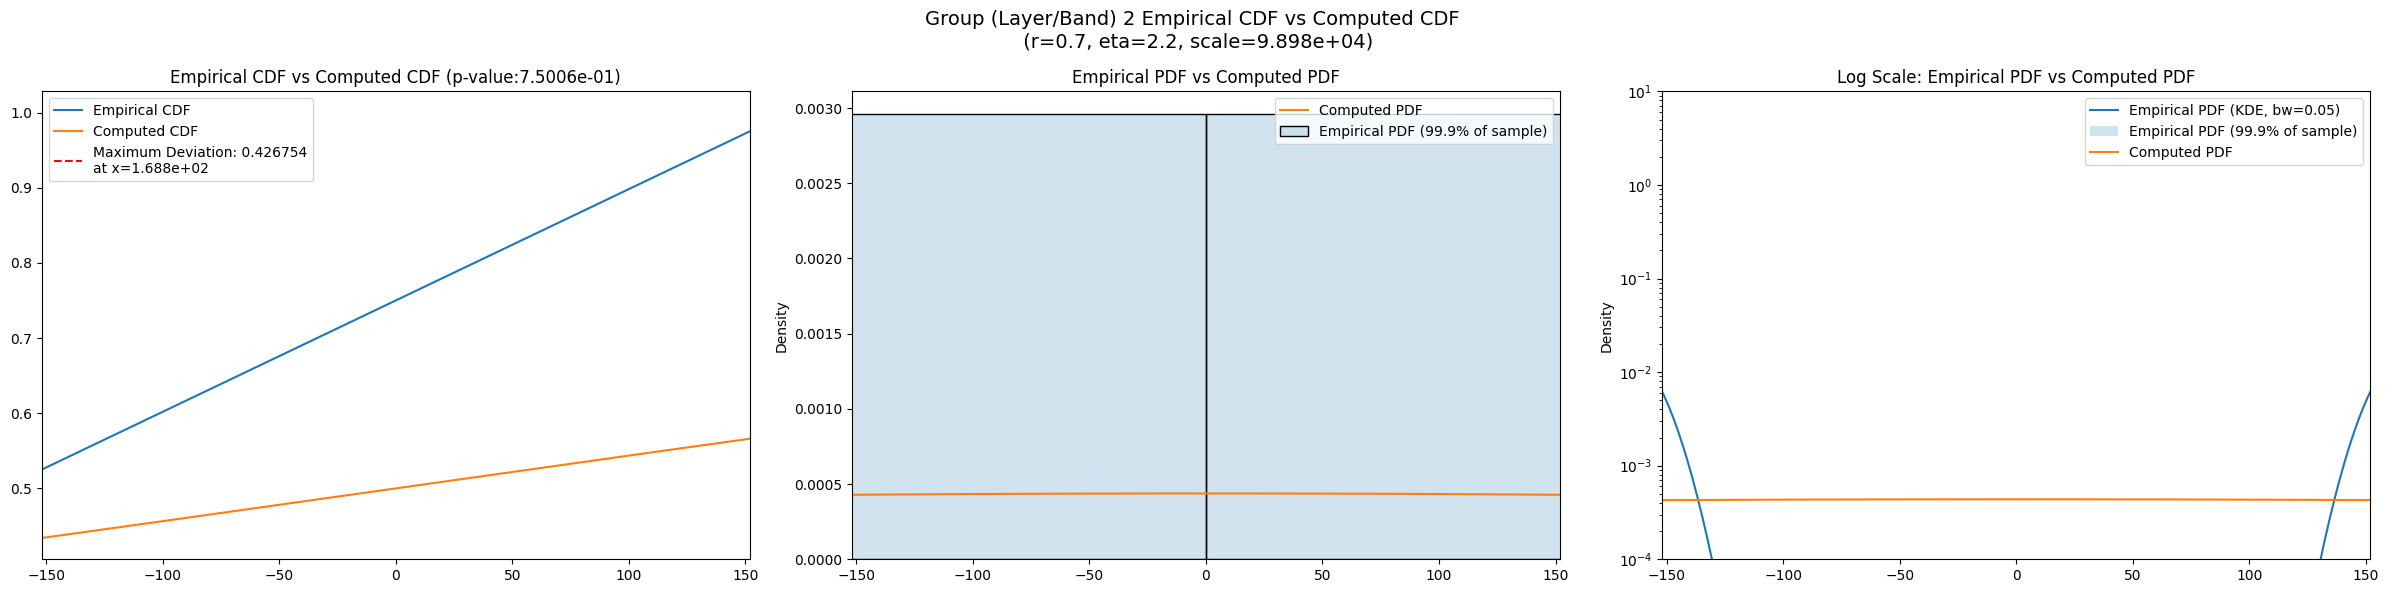

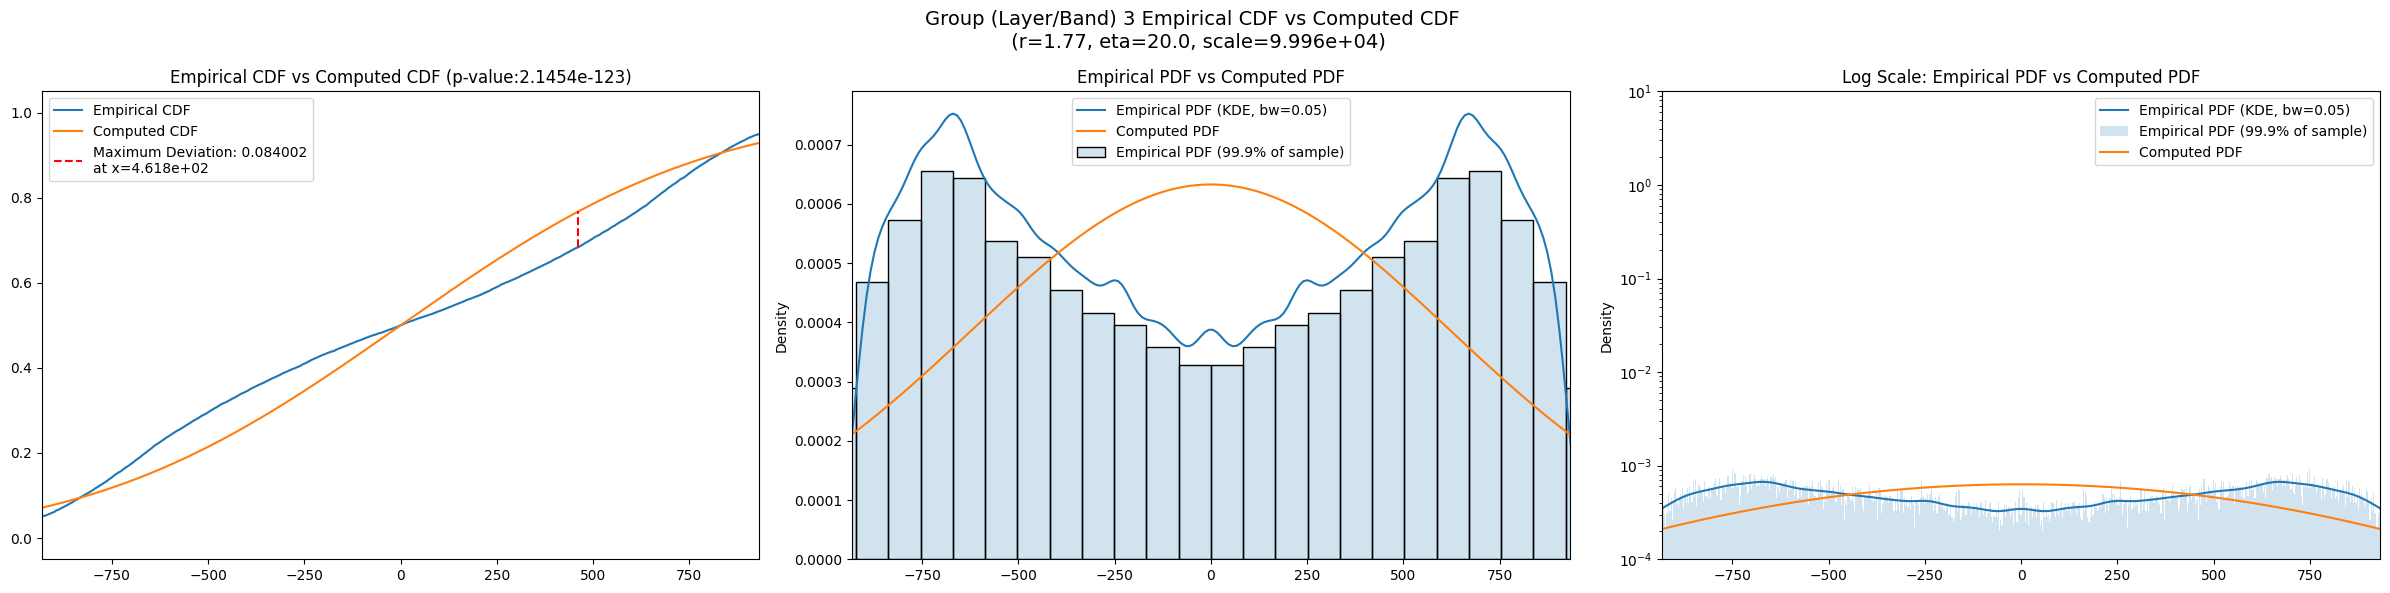

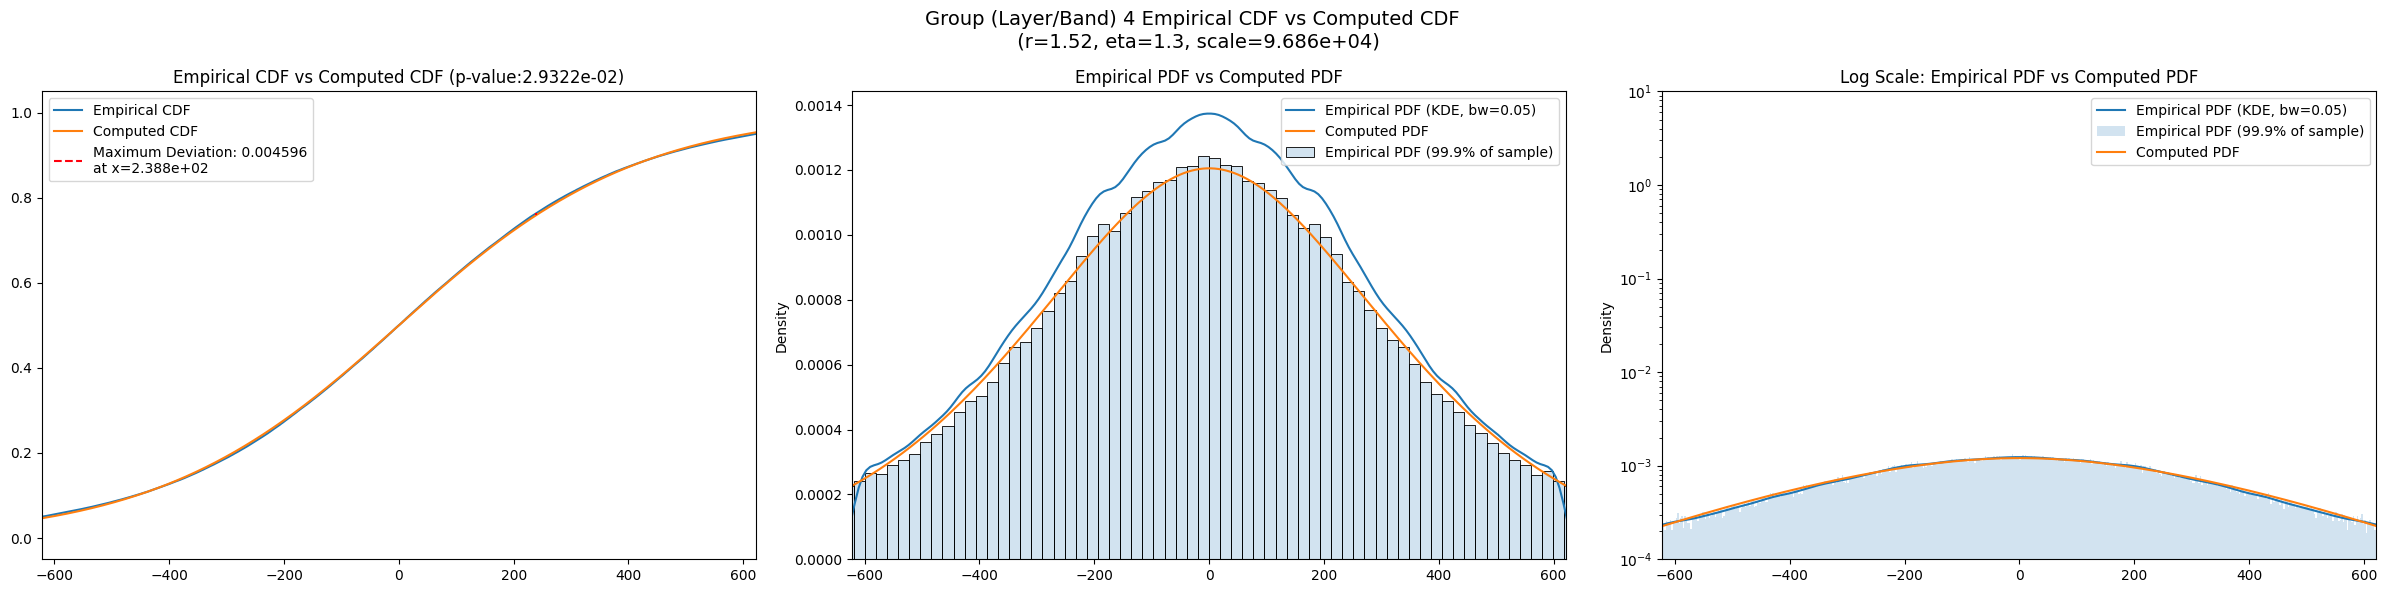

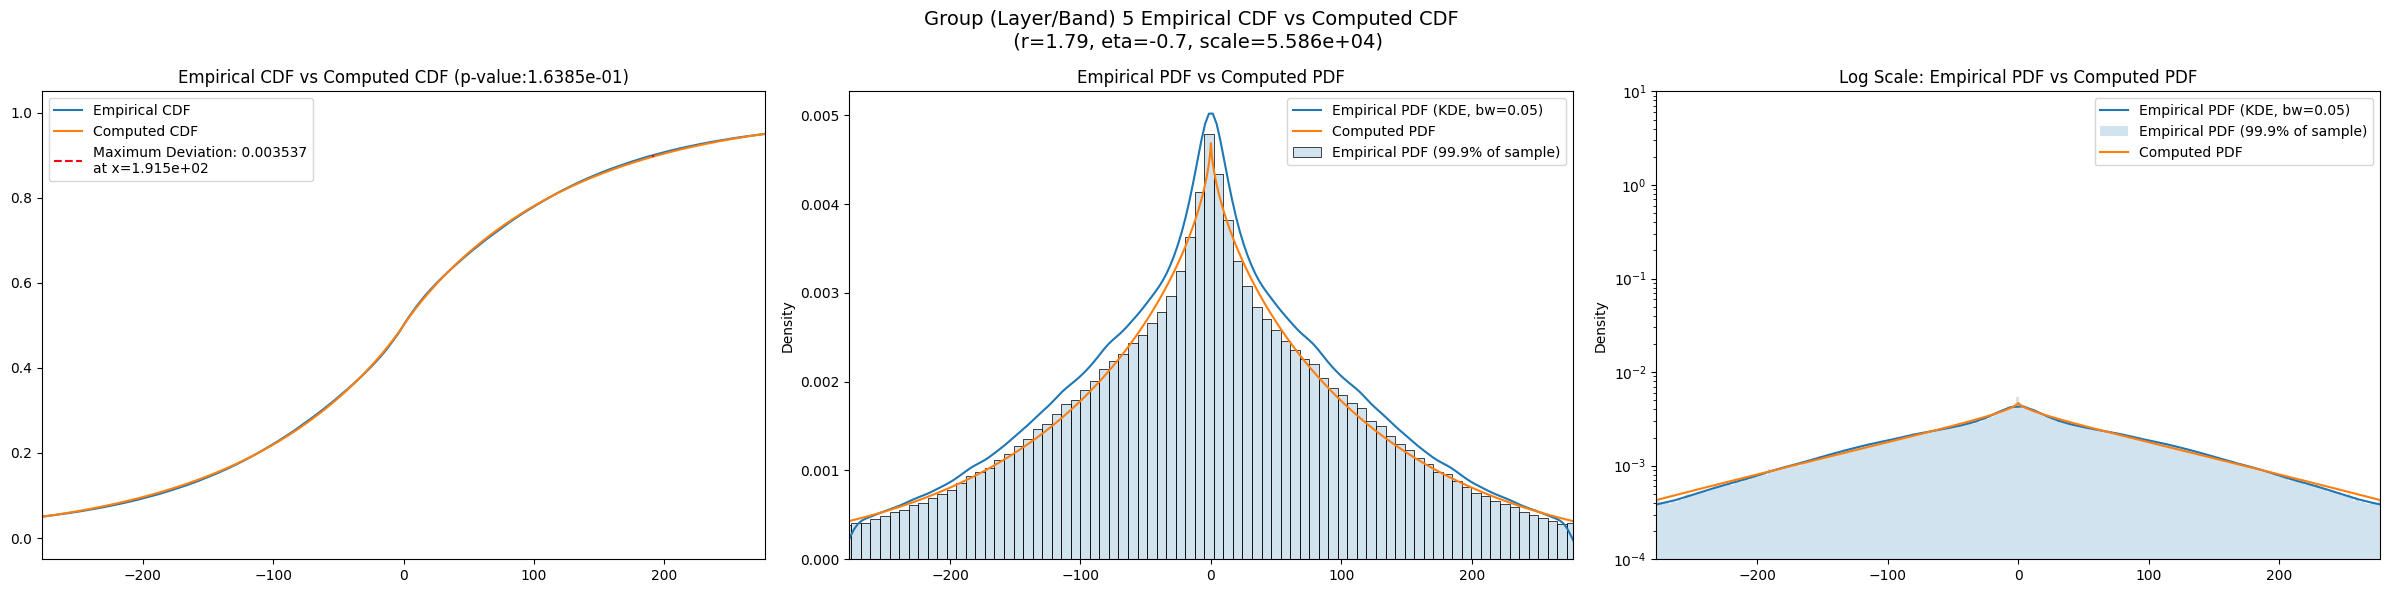

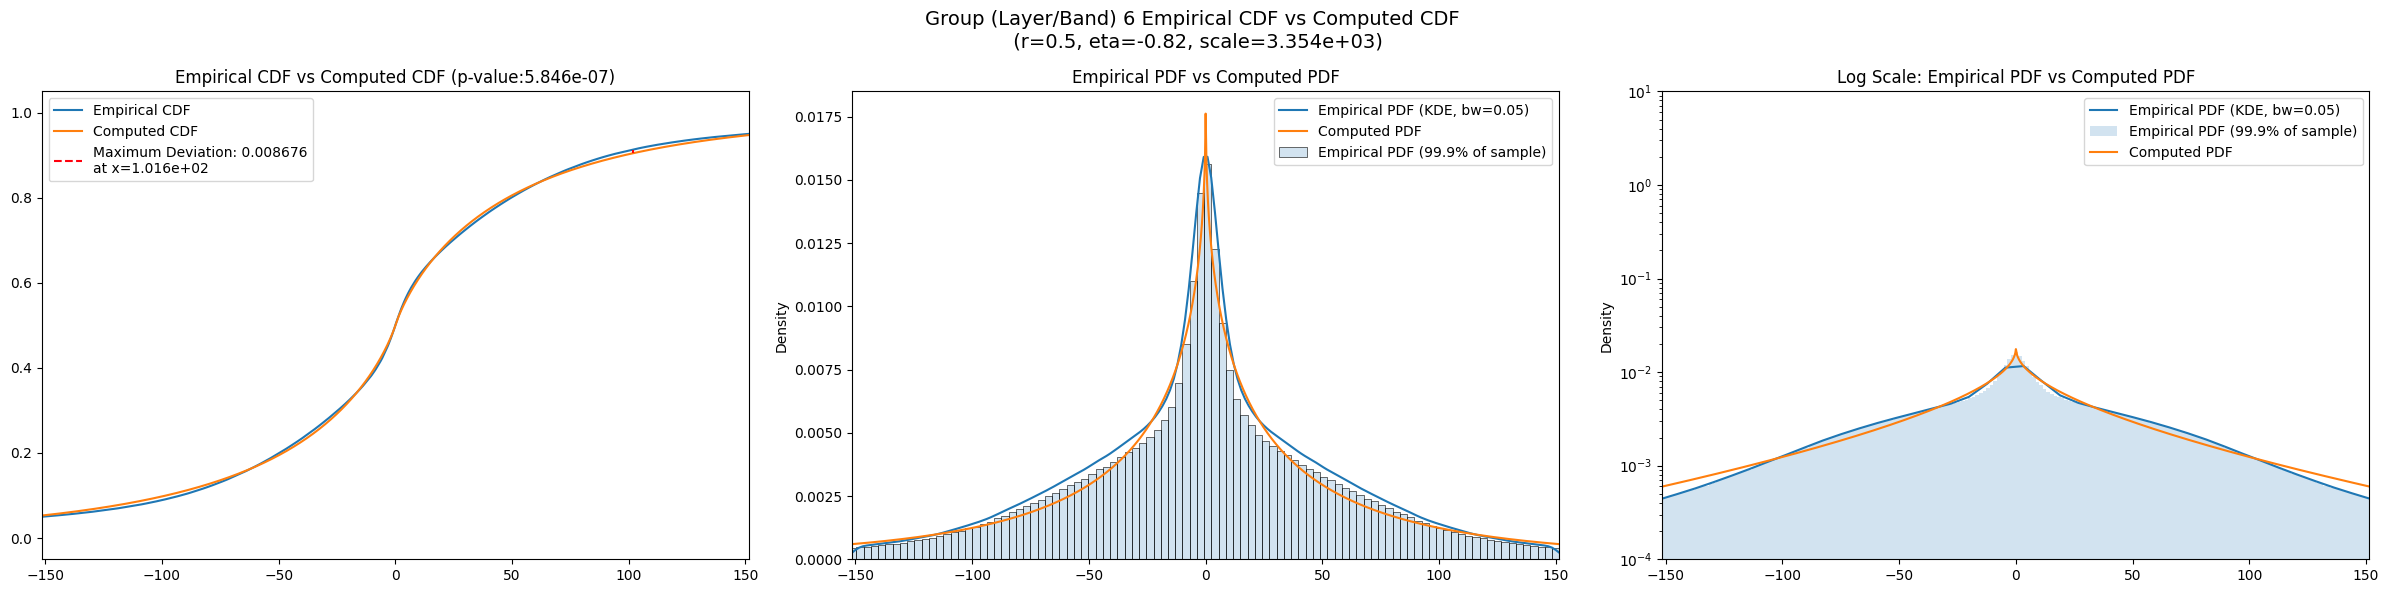

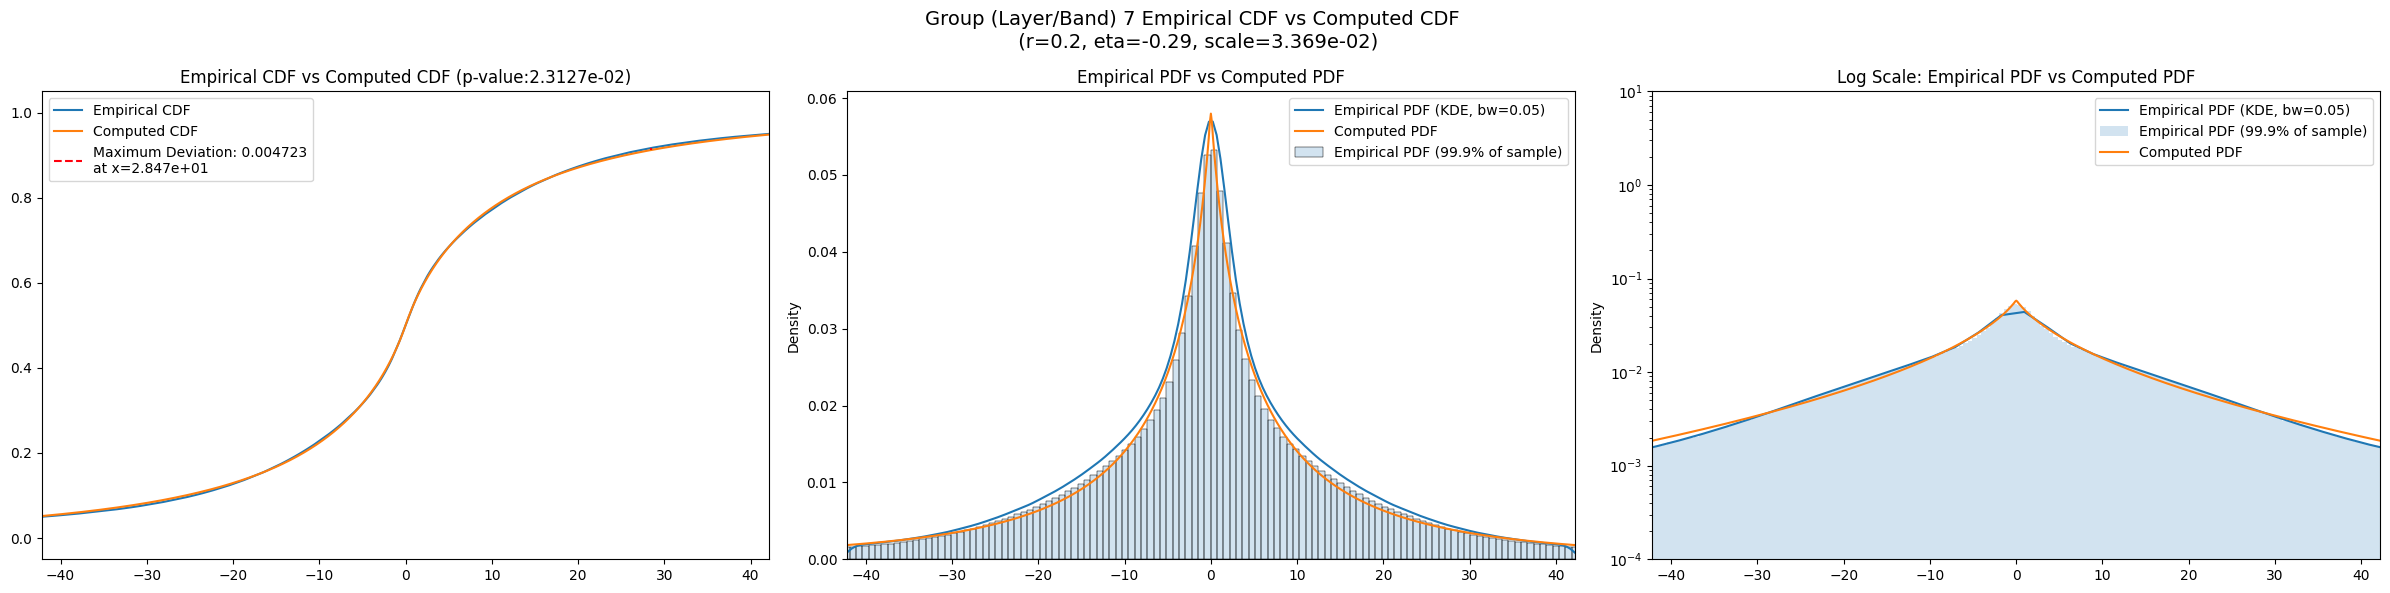

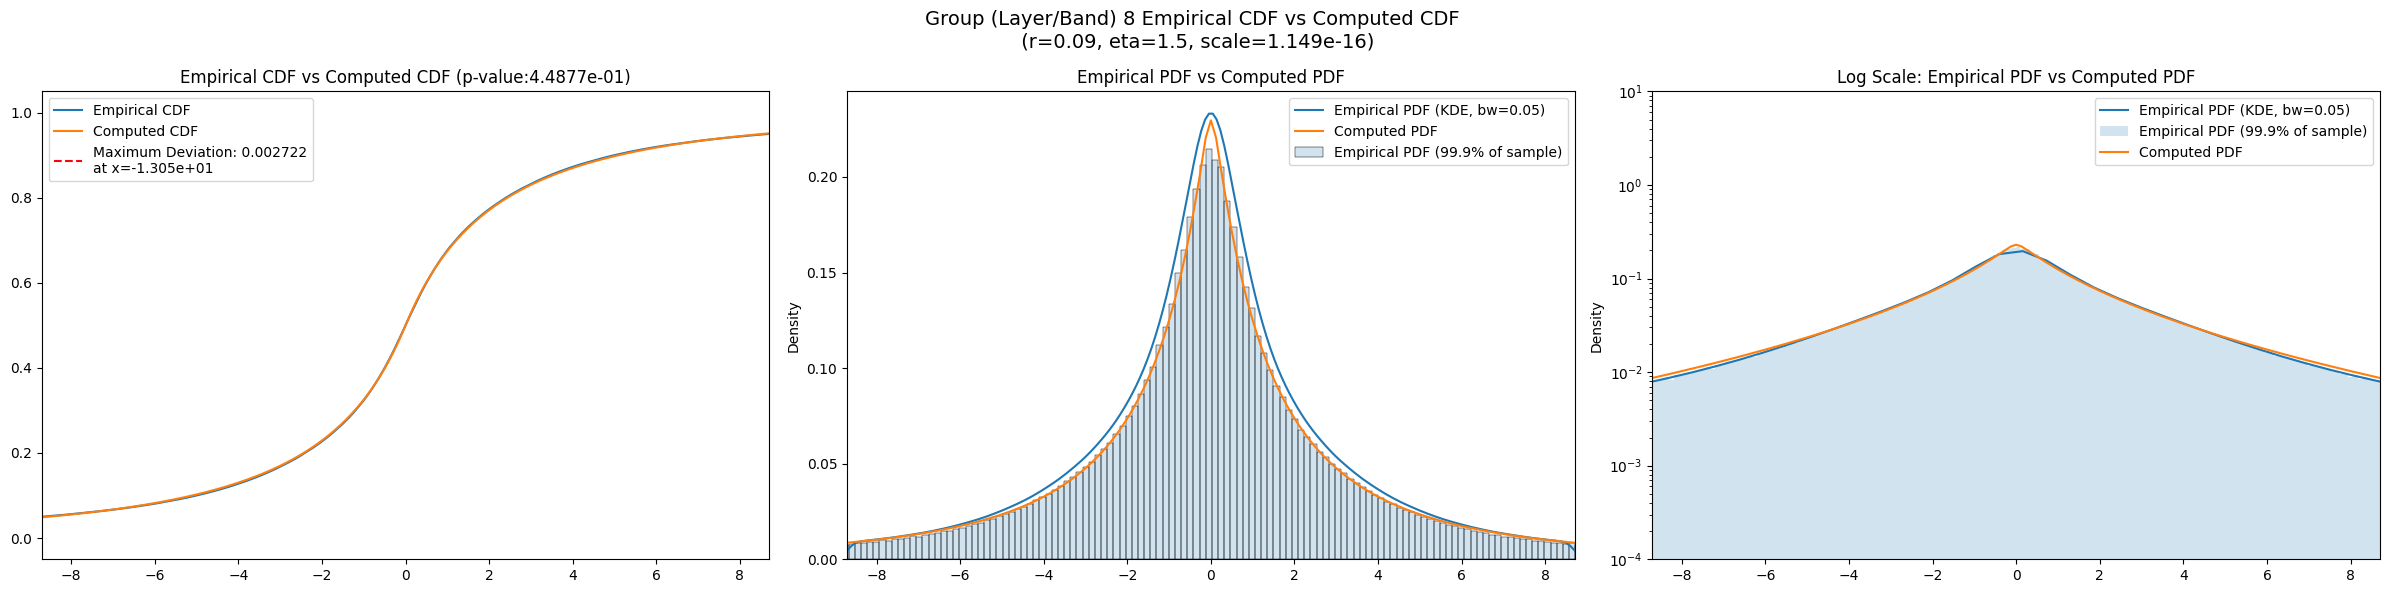

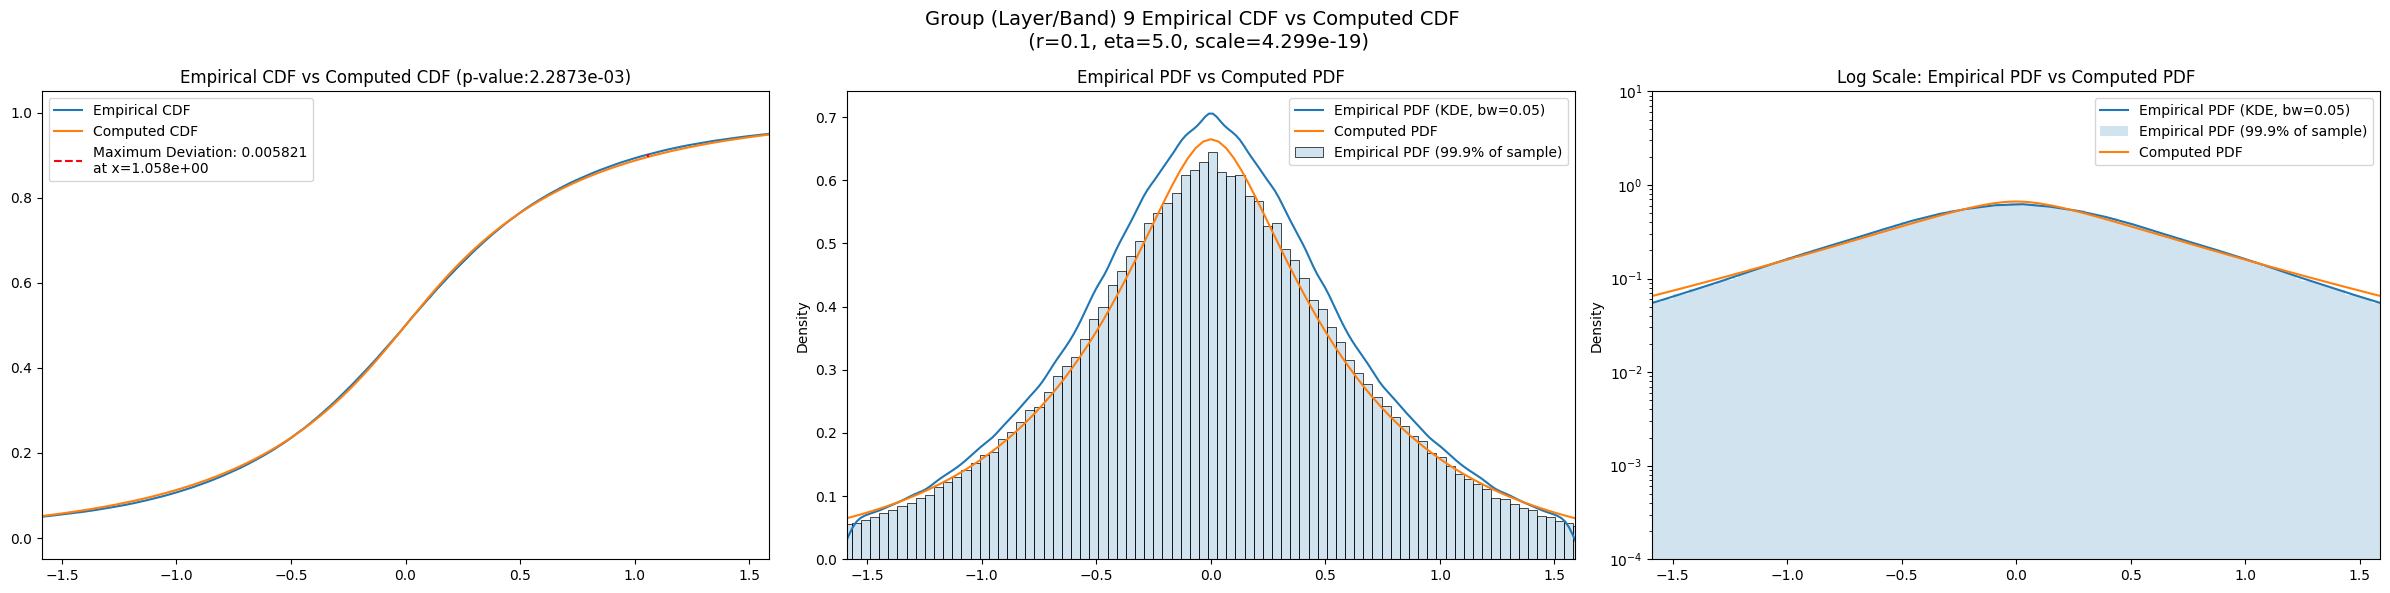

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var      var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                      
2      1.128047e+06       0.000000  2.227615e+06   -1.049854         NaN   
3      4.056535e+05  396542.340000  4.146855e+05   -1.240346   -1.274471   
4      1.365078e+05  130978.300000  1.420548e+05    0.494698    0.342358   
5      3.048242e+04   28617.070000  3.245099e+04    3.911668    2.808647   
6      1.398417e+04   12737.206000  1.529985e+04   10.707630    9.402235   
7      1.169774e+03    1043.950200  1.302599e+03   16.788366   13.570639   
8      5.038604e+01      41.927715  7.069757e+01  114.181786   14.985191   
9      2.155626e+00       1.522823  4.376486e+00  680.612400   18.725904   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2              NaN              4             0.176801        0.7   
3        -1.203905          20050             0.084276        1.7   
4         0.693687         180942             0.004390        1.5   
5         5.579560         922650             0.003448        1.8   
6        12.093122        4185552             0.009214        0.4   
7        21.554005       17688454             0.005061        0.2   
8       479.179440       72685058             0.003295        0.1   
9      1771.118300      295085108             0.006108        0.1   

       initial_eta  ...  param_gaussian  kstest_stat_gaussian  \
layer               ...                                         
2              2.2  ...      997.038000              0.182797   
3             20.0  ...      728.048000              0.054633   
4              1.3  ...      352.141000              0.011918   
5             -0.7  ...      138.306000              0.028115   
6             -0.7  ...       58.610400              0.049064   
7             -0.3  ...       15.078600              0.055212   
8              1.2  ...        3.181630              0.053324   
9              5.0  ...        0.790404              0.029436   

       kstest_pval_gaussian  param_laplace  kstest_stat_laplace  \
layer                                                             
2              9.957150e-01     863.429000             0.161233   
3              1.865310e-52     645.772000             0.077693   
4              9.407970e-23     310.337000             0.018435   
5              0.000000e+00     119.486000             0.005107   
6              0.000000e+00      50.347900             0.026327   
7              0.000000e+00      13.220800             0.029884   
8              0.000000e+00       2.828520             0.027497   
9              0.000000e+00       0.688098             0.010253   

       kstest_pval_laplace     param_t  kstest_stat_t  kstest_pval_t  \
layer                                                                  
2             9.993380e-01  702.343000       0.166250   9.988880e-01   
3            1.036720e-105  543.950000       0.076807  2.557290e-103   
4             7.538150e-54  247.567000       0.023121   1.854510e-84   
5             2.520190e-21   99.357900       0.011320  3.990900e-103   
6             0.000000e+00   40.455000       0.030527   0.000000e+00   
7             0.000000e+00   10.350000       0.030889   0.000000e+00   
8             0.000000e+00    2.209250       0.024769   0.000000e+00   
9             0.000000e+00    0.561366       0.002563   0.000000e+00   

       kstest_pval_gengamma  
layer                        
2              9.972351e-01  
3             4.020578e-124  
4              1.969018e-03  
5              6.764329e-10  
6             8.915157e-263  
7             4.178128e-284  
8              0.000000e+00  
9              0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.176801                 0.623939          0.176801   
3                 0.084276                 0.009583          0.084204   
4                 0.004390                 0.003192          0.004373   
5                 0.003448                 0.001414          0.003438   
6                 0.009214                 0.000664          0.008495   
7                 0.005061                 0.000323          0.004297   
8                 0.003295                 0.000159          0.003196   
9                 0.006108                 0.000079          0.006108   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.182797             0.161233       0.166250  
3                  0.054633             0.077693       0.076807  
4                  0.011918             0.018435       0.023121  
5                  0.028115             0.005107       0.011320  
6                  0.049064             0.026327       0.030527  
7                  0.055212             0.029884       0.030889  
8                  0.053324             0.027497       0.024769  
9                  0.029436             0.010253       0.002563

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            1.128047e+06          0.176801    0.70      2.20  9.898170e+04   
3            4.056535e+05          0.084204    1.77     20.00  9.996494e+04   
4            1.365078e+05          0.004373    1.52      1.30  9.685953e+04   
5            2.809923e+04          0.003438    1.79     -0.70  5.586394e+04   
6            1.076644e+04          0.008495    0.50     -0.82  3.354449e+03   
7            1.052170e+03          0.004297    0.20     -0.29  3.369233e-02   
8            4.422889e+01          0.003196    0.09      1.50  1.148771e-16   
9            1.120619e+00          0.006108    0.10      5.00  4.298576e-19   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                    150.0  
6                    375.0  
7                     75.0  
8                     25.0  
9                    350.0

In [21]:
eng.quit()